# 1D Harmonic Oscillator

*Note: This is the first of a series of three jupyter notebooks, and also the one with the most detailed explanations of the process and the code. The other two can be found at this [GitHub repository](https://github.com/javier-rozalen/AJP-Article).*

Here we solve the Harmonic Oscillator (HO) in 1D for a single particle using the NQS method. The Hamiltonian reads, in HO units:

$$\hat{H}=-\frac{1}{2}\frac{d²}{dx²}+\frac{1}{2}mw^2\hat{x}^2,$$

where $m$ is the mass of the particle and $w$ is the angular frequency of the oscillator. 

## Imports
We start our code by importing the necessary modules.

In [1]:
# Imports
import torch, time
from torch import nn, Tensor
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt # Plotting library
from tqdm import tqdm # Progress bar

## General parameters

We define the various parameters and hyperparameters.

In [2]:
# Hardware (CPU or GPU)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 4  # Nodes in the hidden layer

# Network parameters.
seed = 1                                       # Seed of the random number generator
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

# Training hyperparameters
epochs = 3000
lr = 2e-2  # Learning rate

# Mesh parameters
Nx = 100                    # Mesh division
train_a = -8                      # Mesh lower limit
train_b = 8                        # Mesh upper limit
h = (train_b - train_a)/(Nx - 1)  # Mesh parameter "h"
wi = torch.empty(Nx, 1).fill_(h)     # Integration weights for this mesh. 
                                    # We are using trapezoids with zero boundary conditions
Q_train = torch.linspace(train_a, train_b, Nx, requires_grad=True, device=device)  

target = (1/np.pi)**(1/4) * torch.exp(-Q_train.pow(2)/2).to(device)

## The neural network

We now create the neural network. In PyTorch every neural network must be created as a child of the ```nn.Module``` class. Inside the ```__init__``` method we define the layers. In our case we have a single hidden layer, and therefore a single activation function and two linear transformations (one at each "side" of the hidden layer). Then, inside the block ```with torch.no_grad():``` we define the initial parameters of the network.

Finally, inside the ```forward``` method we set the connections between the different elements of the network, this is, we set the network architecture.

In [3]:
class HarmonicNQS(nn.Module):
    def __init__(self, W1, B, W2):
        super(HarmonicNQS, self).__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Sigmoid()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=False)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o

The network we have just created has the following graph representation:

<img src="simple_ann.PNG"
     alt="Markdown Monster icon"
     style="float: center;" 
     width="500"
     height="400"/>
     
We can check that our code is actually producing this neural network with the following syntax: 

In [4]:
net = HarmonicNQS(W1, B, W2).to(device)
print("NN architecture:\n", net)

NN architecture:
 HarmonicNQS(
  (lc1): Linear(in_features=1, out_features=4, bias=True)
  (actfun): Sigmoid()
  (lc2): Linear(in_features=4, out_features=1, bias=False)
)


## The optimizer

We chose RMSprop as our optimizer which in our case updates the parameters according to:

$$ g_t \longleftarrow \nabla_{\theta}\mathcal{L_t(\theta_{t-1})},$$

$$ v_t \longleftarrow \alpha v_{t-1}+(1-\alpha)(g_t)^2,$$

$$\theta_t \longleftarrow \theta_{t-1}-\gamma\frac{g_t}{\sqrt{v_t+\epsilon}},$$

where $\gamma$ is the learning rate and $\epsilon$ is a constant added for the sake of numerical stability. The RMSprop optimizer is actually slightly more involved than this, in the sense that it admits further hyperparameters such as momentum, weight decay, and so forth. The interested reader can find the full PyTorch implementation of RMSprop at this [link](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html). In practice, the above formulas are already implemented in the PyTorch engine, inside the ```torch.optim``` class, and we can define our RMSprop optimizer in a single line of code:

In [5]:
optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)

## The loss function

Now we must define the loss function, which in our case is the energy expectation computed with the HO Hamiltonian and our NQS. This is,
$$\newcommand{\bra}[1]{{ \left\langle #1 \right|} }
\newcommand{\ket}[1]{{ \left|  #1 \right\rangle } }
\mathcal{L}=\frac{\bra{\psi_\theta}\hat{H}\ket{\psi_\theta}}{\bra{\psi_\theta}\psi_\theta\rangle}. $$

This expression can be evaluated as two integrals in position space:

$$\bra{\psi_\theta}\hat{H}\ket{\psi_\theta}=\int_{-\infty}^{+\infty} \psi_\theta\hat{H}\psi_\theta dx$$

$$ \bra{\psi_\theta}\psi_\theta\rangle=\int_{-\infty}^{+\infty} \psi_\theta^2 dx$$

The first integral can be rewritten so that the second derivative does not appear. This will be useful when computing the loss function. The "trick" is to integrate the kinetic term by parts and impose that 

$$ \lim_{x\to \pm\infty}\psi_\theta(x) = 0. $$

After this step we can discretize the integrals according to our lattice:

$$ \bra{\psi_\theta}\hat{H}\ket{\psi_\theta}=\frac{1}{2}\int_{-\infty}^{+\infty}\bigg [\bigg (\frac{d\psi_\theta(x)}{dx}\bigg )^2+x^2\psi_\theta^2(x)\bigg ]dx \approx \frac{1}{2}\sum_{i=1}^{N_x} w_i \bigg[\bigg(\frac{d\psi_\theta(x_i)}{dx}\bigg)^2+x^2\psi_\theta^2(x_i)\bigg], $$

$$\bra{\psi_\theta}\psi_\theta\rangle\approx \sum_{i=1}^{N_x} w_i \psi_\theta^2(x_i)\equiv N.$$

In PyTorch, the loss function must be defined as an external function that returns (at least) the scalar loss value computed with the NQS at a given epoch. Below is our implementation.

In [6]:
def loss_fn():  
    psi = net(X)
    psi2 = net(X_det).pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    N = torch.tensordot(psi2, wi)                       
    U =  (1/2) * torch.tensordot(X_det.pow(2) * psi2, wi) / N # Potential energy
    K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N # Kinetic energy
    E = U + K # Total energy
    
    return E, U, K, psi, psi / torch.sqrt(N) 

*Note 1: When performing operations on PyTorch tensors, it is important to write them using built-in tensor operations, avoiding manual loops as far as possible. This dramatically enhances the code performance, for PyTorch will automatically parallelize these operations in our hardware.*

*Note 2: notice that, in computing the potential energy ```U``` we used the syntax ```X.clone().detach()``` in including the positions X. This is because we only want to track those operations on tensor ```X``` that lead to computing $\psi_\theta'(X)$, and this only happens in the kinetic term. While this is not strictly necessary, since this will not affect the backpropagation to the NQS parameters (see section [Extra: Computation Graph](#Extra:-Computation-Graph)), it will free some memory.*

## Plotting

We set the function that does the plots periodically. Please note that the syntax is slightly more intricate than strictly necessary; this is intended to improve the final visualization of the plots in a jupyter notebook environment.

In [7]:
def pic(i, x, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    # Overlap
    ax1.set_title('Normalized wave function')
    wf = psi_normalized.detach().numpy()
    if np.max(wf) < 0: wf = -wf
    ax1.set_ylim(-0.05, np.max(wf)*1.1)
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x.detach().numpy())
        ax1.lines[1].set_ydata(target.detach().numpy())
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
        ax1.plot(x.detach().numpy(), target.detach().numpy(), linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend()
    
    # Wave function
    ax2.set_title('NQS wave function')
    wf = psi.detach().numpy()
    if np.max(wf) < 0: wf = -wf 
    ax2.set_ylim(-0.05, np.max(wf)*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x.detach().numpy())
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x.detach().numpy(), wf, 
                 label='$\psi_\mathrm{NQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)-0.5, np.ones(i+1)-0.75][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)-0.5, linestyle='--', label='$E_0$', color='b')
        ax3.plot(x, np.ones(i+1)-0.75, linestyle='--', label='$U_0, K_0$', color='g')
        ax3.legend()
        
    fig.canvas.draw()

## Training the network: ground state, $\ket{\psi_0}$

We are now ready to train the neural network. The first part of the code is related to the plots that will be periodically created during the training, and the actual training happens inside the ```for``` loop. The key lines of code are the following:

``` optimizer.zero_grad() ``` sets all gradients to zero so as not to accumulate the ones from the previous iteration or epoch.

``` loss.backward() ``` computes the gradient of the loss w.r.t. the parameters passed to the optimizer using the backpropagation algorithm. These gradient components are stored inside the ```.grad```attribute of the tensors with the ```requires_grad``` flag set to ```True```.

``` optimizer.step() ``` updates the parameters $\theta$ making use of the gradient information just computed.



<IPython.core.display.Javascript object>


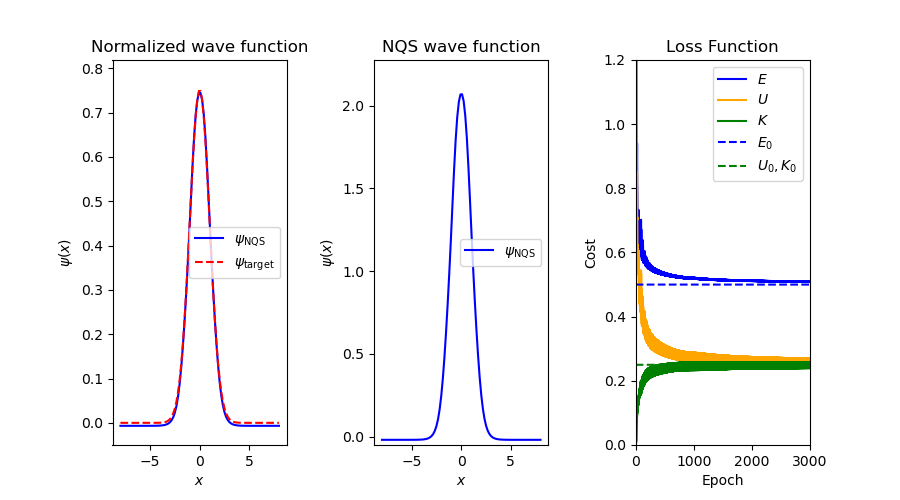

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 510.73it/s]


In [8]:
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Cost")
ax3.set_ylim(0, 1.2)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1) # Training set
X_det = X.clone().detach() # Training set without gradients

# Training
loss0, U, K, psi, psi_normalized = loss_fn()
for i in tqdm(range(epochs), desc="Training the NQS..."):    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss0.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss0, U, K, psi, psi_normalized = loss_fn()    # Energy and \psi calculation
    
    loss_accum.append(loss0.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 100 == 0): # We plot periodically
        pic(i, Q_train, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.01)

E0, psi0 = loss_accum[-1], psi.clone().detach()

*Note: When running the above cell more than once, please take into account that the network is already trained from the first run. To restart the training from scratch, first re-run the code cells of sections [General parameters](#General-parameters), [The neural network](#The-neural-network) and [The optimizer](#The-optimizer).*

In the picture generated above we can see how the network wave function "learns" the solution almost perfectly. The left panel shows manually normalized wave functions, whereas the middle panel shows the bare output of the network. The right panel shows the evolution of the loss with the number of epochs.

## Training the network: first excited state, $\ket{\psi_1}$

We now go for the first excited state. The process is almost identical to that of finding the ground-state wave function, with the fundamental difference that now the Rayleigh-Ritz theorem demands that

$$ \langle\psi_{\theta,0}|\psi_{\theta',1}\rangle = 0, $$

where $\psi_{\theta,0}, \psi_{\theta',1}$ are the ansatz wave functions of the ground and first excited state, respectively. A simple way to impose this condition is to make $\psi_1$ antisymmetric (given that $\psi_0$ is symmetric),

$$ \psi_{\theta',1}(x) \longleftarrow \psi_{\theta',1}(x)-\psi_{\theta',1}(-x) .$$

Notice that such symmetry considerations are valid for any one-dimensional system with a parity-symmetric potential, as explained in the main article. 

In [9]:
def loss_fn_prime(E0, psi0):  
    X_det = X.clone().detach()
    psi = net1(X)-net1(-X)  
    psi2 = psi.pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    # Energy term
    N = torch.tensordot(psi2, wi)                       
    U = (1/2) * torch.tensordot(X_det.pow(2) * psi2, wi) / N  
    K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N              
    E = U + K   

    # Total loss
    L = E
    
    return L, U, K, psi, psi / torch.sqrt(N) 

Now we define a new neural network, which has the exact same architecture as the one used for the ground state. We can do this by creating a new instance of our [previous NQS](#The-neural-network). We also reset the optimizer parameters by redefining it. 

In [10]:
net1 = HarmonicNQS(W1, B, W2).to(device)
optimizer = torch.optim.RMSprop(params=net1.parameters(), lr=lr)

target = (1 / np.sqrt(2))*(np.pi**0.25)*torch.exp(-Q_train.pow(2) / 2)*Q_train

We define a new plotting function,

In [11]:
def pic(i, x, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    # Overlap
    ax1.set_title("Epoch {}".format(i+1))
    wf = psi_normalized.detach().numpy()
    if net1(torch.tensor([[-2.]])).item() > 0.: wf *= -1
    lim_inf, lim_sup = min(min(wf), min(target.detach().numpy())), max(max(wf), max(target.detach().numpy()))
    ax1.set_ylim(lim_inf*1.1, lim_sup*1.1)
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x.detach().numpy())
        ax1.lines[1].set_ydata(target.detach().numpy())
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NN}$', color='b')
        ax1.plot(x.detach().numpy(), target.detach().numpy(), linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend()
    
    # Wave function
    ax2.set_title("Epoch {}".format(i+1))
    wf = psi.detach().numpy()
    if net1(torch.tensor([[-2.]])).item() > 0.: wf *= -1
    lim_inf, lim_sup = min(min(wf), min(target.detach().numpy())), max(max(wf), max(target.detach().numpy()))
    ax2.set_ylim(lim_inf*1.1, lim_sup*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x.detach().numpy())
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x.detach().numpy(), wf, 
                 label='$\psi_\mathrm{NQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)+0.5, np.ones(i+1)-0.25][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)+0.5, linestyle='--', label='$E_0$', color='b')
        ax3.plot(x, np.ones(i+1)-0.25, linestyle='--', label='$U_0, K_0$', color='g')
        ax3.legend()
        
    fig.canvas.draw()

Now we are ready to train our ansatz $\psi_{\theta',1}=\langle x | \psi_{\theta',1}\rangle$.

<IPython.core.display.Javascript object>


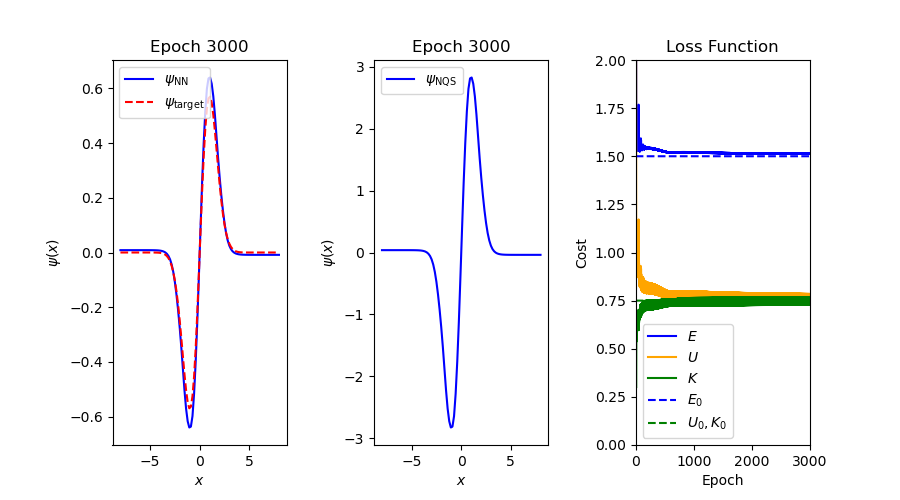

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 483.09it/s]


In [12]:
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Cost")
ax3.set_ylim(0, 2)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)

# Training
loss1, U, K, psi, psi_normalized = loss_fn_prime(E0, psi0)    # Energy and \psi calculation
for i in tqdm(range(epochs), desc="Training the NQS..."):
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss1.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss1, U, K, psi, psi_normalized = loss_fn_prime(E0, psi0)    # Energy and \psi calculation
    
    loss_accum.append(loss1.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 100 == 0): # We plot periodically
        pic(i, Q_train, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.01)
        
E1, psi1 = loss_accum[-1], psi

## Extra: Computation Graph

One might wish to visualize the actual graph computed by the ```autograd``` engine in the forward pass to convince oneself that everything is being properly computed. For that purpose, the Python library found at this [GitHub repository](https://github.com/szagoruyko/pytorchviz) can be used. 

Here we show an example of the graph generated during the training of the ground-state NQS, for the sake of simplicity.

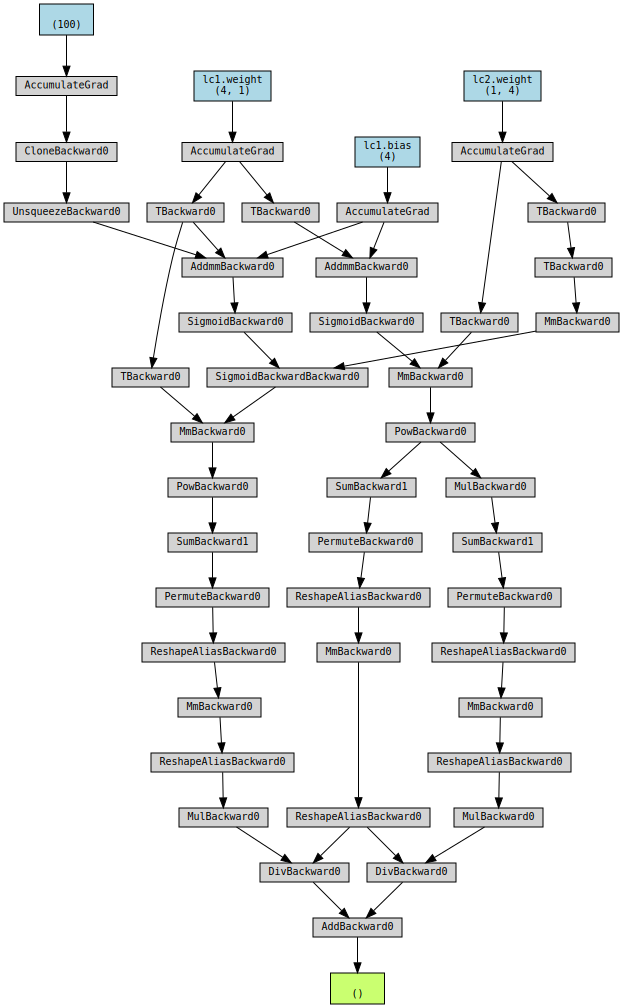

In [13]:
# Imports
from torchviz import make_dot 

make_dot(loss0, params=dict(list(net.named_parameters())))

The reader can easily check that, starting from the *leaves* of the tree (blue boxes at the top), all operations manually performed to these leave tensors appear in the graph in an ordered fashion. The graph additionally contains operations which are applied automatically by PyTorch, such as ```TBackward``` (transpose backward), which are necessary for the correct functioning of the code. 

The green box at the very bottom is called the *root* of the tree, and it represents the tensor w.r.t. which the gradients are computed, generally the loss function. 

Simply put, the purpose of this graph is to indicate to the ```autograd``` engine the order in which the chain rule is to be applied in the backpropagation of the error to the network parameters. Further explanations on this matter can fe bound at the official PyTorch site: [How Computational Graphs are Constructed in PyTorch](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/).